In [26]:
# ==========================================================
# COS30082 – Baseline Model A: Mix-Stream CNN (ResNet50)
# Cross-Domain Plant Species Identification
# ==========================================================

!pip install -q tensorflow matplotlib pandas tqdm scikit-learn

from google.colab import drive
drive.mount('/content/drive')

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math
from tqdm import tqdm

print("TensorFlow version:", tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow version: 2.19.0


In [27]:
# ==========================================================
# 1) PATH SETUP
# ==========================================================

BASE_DIR = "/content/drive/MyDrive/AML_ass2"
LIST_DIR = f"{BASE_DIR}/list"

TRAIN_TXT = f"{LIST_DIR}/train.txt"
TEST_TXT  = f"{LIST_DIR}/test.txt"
GT_TXT    = f"{LIST_DIR}/groundtruth.txt"
SPECIES   = f"{LIST_DIR}/species_list.txt"
PAIR_TXT  = f"{LIST_DIR}/class_with_pairs.txt"
NOPAIR_TXT= f"{LIST_DIR}/class_without_pairs.txt"

for p in [TRAIN_TXT, TEST_TXT, GT_TXT, SPECIES]:
    assert os.path.exists(p), f"Missing: {p}"

print("All files OK.\n")


All files OK.



In [28]:
# ==========================================================
# 2) CLEAN species_list.txt
# ==========================================================

clean = []
with open(SPECIES) as f:
    for line in f:
        line = line.strip().replace(";", "")
        if line:
            clean.append(line)

with open(SPECIES, "w") as f:
    f.write("\n".join(clean))

print("species_list.txt cleaned.\n")

species_list.txt cleaned.



In [29]:
# ==========================================================
# 3) CLASS MAPPING
# ==========================================================

id_to_name = {}
with open(SPECIES) as f:
    for line in f:
        cid, name = line.split(maxsplit=1)
        id_to_name[int(cid)] = name

all_ids = sorted(id_to_name.keys())
id_to_idx = {cid:i for i,cid in enumerate(all_ids)}
idx_to_id = {i:cid for cid,i in id_to_idx.items()}
idx_to_name = {i:id_to_name[idx_to_id[i]] for i in idx_to_id}

NUM_CLASSES = len(id_to_idx)
print("Classes:", NUM_CLASSES)


Classes: 100


In [30]:
# ==========================================================
# 4) TRAINING SET (FULL — NO SPLIT)
# ==========================================================

train_paths, train_labels = [], []

with open(TRAIN_TXT) as f:
    for line in f:
        rel, cid = line.strip().split()
        full = os.path.join(BASE_DIR, rel)
        cid = int(cid)
        if cid in id_to_idx:
            train_paths.append(full)
            train_labels.append(id_to_idx[cid])

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

print("Training samples:", len(train_paths), "\n")


Training samples: 4744 



In [31]:
# ==========================================================
# 5) TF.DATA PIPELINE
# ==========================================================

IMG_SIZE = 224
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

def decode_resize(path):
    x = tf.io.read_file(path)
    x = tf.image.decode_jpeg(x, 3)
    x = tf.image.resize(x, [IMG_SIZE, IMG_SIZE])
    return x

def augment(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, 0.2)
    return x

def preprocess_res(x):
    return tf.keras.applications.resnet.preprocess_input(x)

def preprocess_eff(x):
    return tf.keras.applications.efficientnet.preprocess_input(x)

def make_train(paths, labels, preprocess_func):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    def _load(p, y):
        x = decode_resize(p)
        x = augment(x)
        x = preprocess_func(x)
        return x, y
    return ds.shuffle(2048).map(_load, AUTOTUNE).batch(BATCH).prefetch(AUTOTUNE)

def make_test(paths, preprocess_func):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    def _load(p):
        x = decode_resize(p)
        x = preprocess_func(x)
        return x
    return ds.map(_load, AUTOTUNE).batch(BATCH)

train_ds = make_train(train_paths, train_labels, preprocess_res)
train_ds = make_train(train_paths, train_labels, preprocess_eff)

In [14]:
# ==========================================================
# 6) BUILD RESNET50 MIX-STREAM CNN
# ==========================================================

base = tf.keras.applications.ResNet50(
    weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base.trainable = False

inp = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = base(inp, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Mix-stream structure (two branches)
b1 = tf.keras.layers.Dense(512, activation="relu")(x)
b1 = tf.keras.layers.Dropout(0.5)(b1)

b2 = tf.keras.layers.Dense(256, activation="relu")(x)
b2 = tf.keras.layers.Dropout(0.3)(b2)

merged = tf.keras.layers.Concatenate()([b1, b2])
out = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(merged)

model = tf.keras.Model(inp, out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="top1"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5"),
    ],
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_3[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │  1,049,088 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 768)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 100)       │     76,900 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,238,244 (96.28 MB)

 Trainable params: 1,650,532 (6.30 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:

# ==========================================================
# 7) TRAIN MODEL (Stage 1 – Frozen ResNet)
# ==========================================================

history = model.fit(train_ds, epochs=20)


Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 66s 270ms/step - loss: 4.5086 - top1: 0.0937 - top5: 0.2402
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - loss: 3.0504 - top1: 0.2631 - top5: 0.5313
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 39s 259ms/step - loss: 2.4893 - top1: 0.3612 - top5: 0.6587
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 37s 246ms/step - loss: 2.1677 - top1: 0.4370 - top5: 0.7254
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - loss: 1.9789 - top1: 0.4654 - top5: 0.7574
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 38s 255ms/step - loss: 1.7199 - top1: 0.5395 - top5: 0.8007
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 237ms/step - loss: 1.5829 - top1: 0.5673 - top5: 0.8272
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 37s 246ms/step - loss: 1.4306 - top1: 0.5989 - top5: 0.8575
Epoch 9/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 37s 250ms/step - loss: 1.2645 - top1: 0.6433 - top5: 0.8822
Epoch 10/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 238ms/step - loss: 1.2103 - top1: 0.6504 - top5: 0.8900

In [16]:
# ==========================================================
# 8) FINE-TUNE LAST 120 LAYERS
# ==========================================================

for layer in base.layers[-120:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="top1"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5"),
    ],
)

history_ft = model.fit(train_ds, epochs=10)


Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 106s 401ms/step - loss: 1.6281 - top1: 0.5939 - top5: 0.8390
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 39s 262ms/step - loss: 0.8547 - top1: 0.7457 - top5: 0.9459
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - loss: 0.5540 - top1: 0.8272 - top5: 0.9783
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - loss: 0.4198 - top1: 0.8823 - top5: 0.9813
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - loss: 0.3012 - top1: 0.9119 - top5: 0.9926
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - loss: 0.2572 - top1: 0.9226 - top5: 0.9940
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 39s 263ms/step - loss: 0.2657 - top1: 0.9194 - top5: 0.9956
Epoch 8/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 40s 266ms/step - loss: 0.1970 - top1: 0.9430 - top5: 0.9966
Epoch 9/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 39s 262ms/step - loss: 0.1577 - top1: 0.9553 - top5: 0.9989
Epoch 10/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - loss: 0.1583 - top1: 0.9545 - top5: 0.995

In [17]:

# ==========================================================
# 9) TEST SET EVALUATION
# ==========================================================

test_paths = [os.path.join(BASE_DIR, p.strip()) for p in open(TEST_TXT)]
test_labels = np.array([
    id_to_idx[int(gt)]
    for _, gt in (line.split() for line in open(GT_TXT))
])

test_ds  = make_test(test_paths, preprocess_res)

probs = model.predict(test_ds)
pred_top1 = probs.argmax(1)
pred_top5 = np.argsort(-probs, axis=1)[:, :5]

# Top-N metrics
top1 = np.mean(pred_top1 == test_labels)
top5 = np.mean([test_labels[i] in pred_top5[i] for i in range(len(test_labels))])

print("\n=== TEST RESULTS ===")
print(f"Top-1 Accuracy : {top1*100:.2f}%")
print(f"Top-5 Accuracy : {top5*100:.2f}%")

# ==========================================================
# 10) PAIR vs NON-PAIR ACCURACY
# ==========================================================

pair_ids = set(int(x.strip()) for x in open(PAIR_TXT))
pair_mask     = np.array([idx_to_id[t] in pair_ids for t in test_labels])
nopair_mask   = ~pair_mask

pair_top1  = np.mean(pred_top1[pair_mask] == test_labels[pair_mask])
pair_top5  = np.mean([test_labels[i] in pred_top5[i] for i in range(len(test_labels)) if pair_mask[i]])

nopair_top1 = np.mean(pred_top1[nopair_mask] == test_labels[nopair_mask])
nopair_top5 = np.mean([test_labels[i] in pred_top5[i] for i in range(len(test_labels)) if nopair_mask[i]])

print("\n=== Pair / No-Pair Accuracy ===")
print(f"Pair Top-1  : {pair_top1*100:.2f}%")
print(f"Pair Top-5  : {pair_top5*100:.2f}%")
print(f"No-Pair Top-1: {nopair_top1*100:.2f}%")
print(f"No-Pair Top-5: {nopair_top5*100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 867ms/step

=== TEST RESULTS ===
Top-1 Accuracy : 43.96%
Top-5 Accuracy : 63.77%

=== Pair / No-Pair Accuracy ===
Pair Top-1  : 59.48%
Pair Top-5  : 85.62%
No-Pair Top-1: 0.00%
No-Pair Top-5: 1.85%


<Figure size 1400x1200 with 0 Axes>

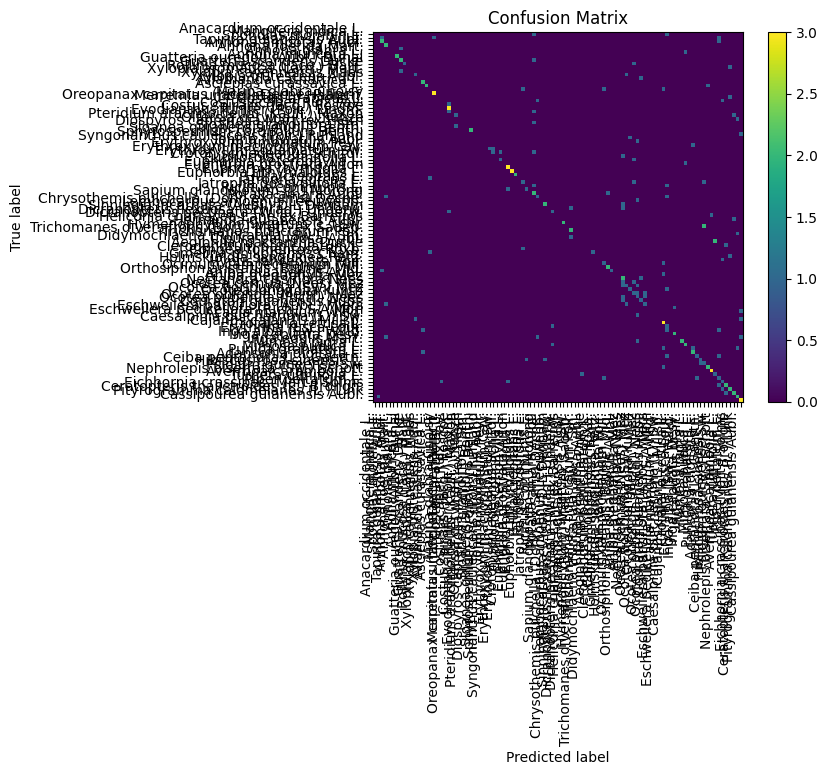

In [18]:
# ==========================================================
# 11) CONFUSION MATRIX
# ==========================================================

cm = confusion_matrix(test_labels, pred_top1)
plt.figure(figsize=(14,12))
disp = ConfusionMatrixDisplay(cm, display_labels=[idx_to_name[i] for i in range(NUM_CLASSES)])
disp.plot(include_values=False, cmap="viridis", xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()


Displaying sample test predictions…


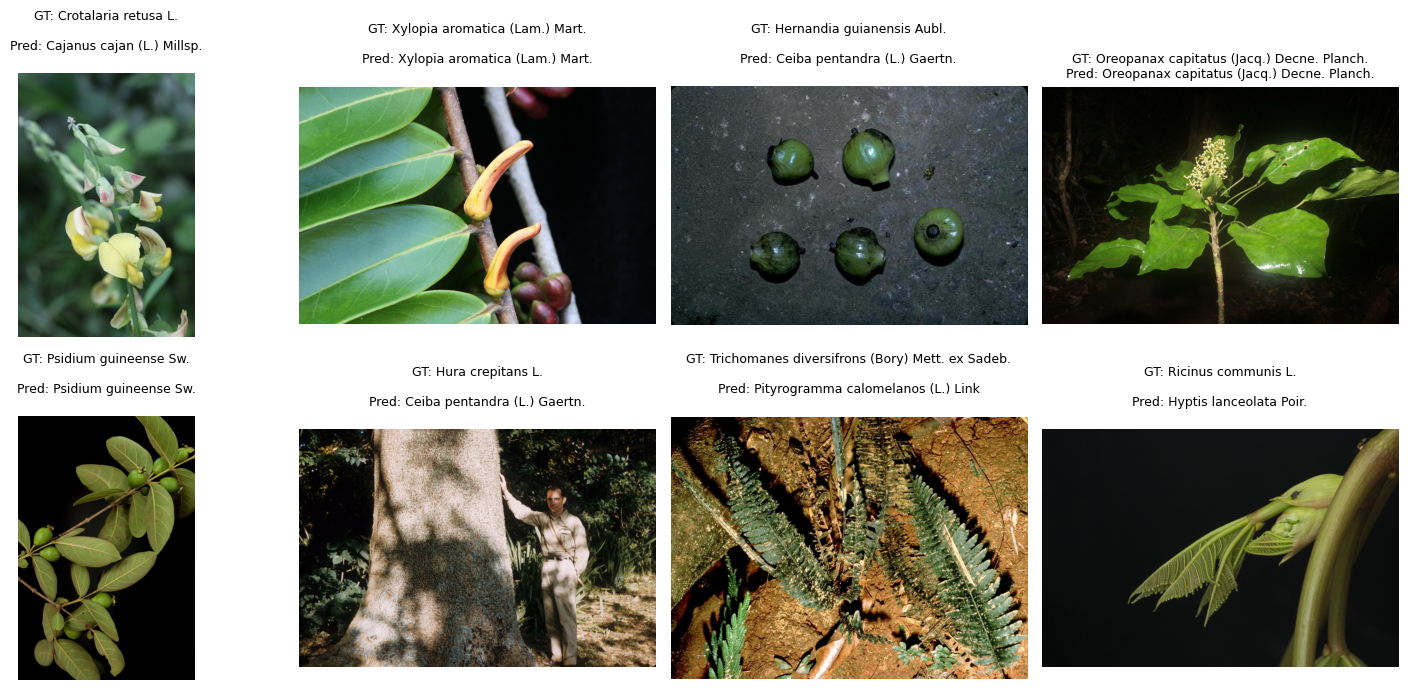

In [19]:
# ==========================================================
# 12) SHOW TEST EXAMPLES
# ==========================================================

def show_examples(k=8):
    sel = np.random.choice(len(test_paths), size=k, replace=False)
    plt.figure(figsize=(15,7))
    for n,i in enumerate(sel,1):
        img = plt.imread(test_paths[i])
        plt.subplot(2, math.ceil(k/2), n)
        plt.imshow(img); plt.axis("off")
        gt = idx_to_name[test_labels[i]]
        pr = idx_to_name[pred_top1[i]]
        plt.title(f"GT: {gt}\nPred: {pr}", fontsize=9)
    plt.tight_layout()
    plt.show()

print("\nDisplaying sample test predictions…")
show_examples(8)

In [32]:
# ==========================================================
# PART-A2) EfficientNet-B0 Mix-Stream CNN
# ==========================================================

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base.trainable = False

inp = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = base(inp, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Mix-stream (two branches)
b1 = tf.keras.layers.Dense(512, activation="relu")(x)
b1 = tf.keras.layers.Dropout(0.5)(b1)

b2 = tf.keras.layers.Dense(256, activation="relu")(x)
b2 = tf.keras.layers.Dropout(0.3)(b2)

merged = tf.keras.layers.Concatenate()([b1, b2])
out = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(merged)

model = tf.keras.Model(inp, out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="top1"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5"),
    ],
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ input_layer_7[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 512)       │    655,872 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 768)       │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 100)       │     76,900 │ concatenate_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,110,279 (19.49 MB)

 Trainable params: 1,060,708 (4.05 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [33]:
# ==========================================================
# 7) TRAIN MODEL – Stage 1 (Frozen Backbone)
# ==========================================================

history = model.fit(train_ds, epochs=20)


Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 72s 338ms/step - loss: 4.1259 - top1: 0.1199 - top5: 0.2821
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 198ms/step - loss: 2.5319 - top1: 0.3728 - top5: 0.6502
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 198ms/step - loss: 1.9283 - top1: 0.5086 - top5: 0.7682
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 201ms/step - loss: 1.5391 - top1: 0.5916 - top5: 0.8440
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 42s 205ms/step - loss: 1.2634 - top1: 0.6573 - top5: 0.8881
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - loss: 1.0946 - top1: 0.6976 - top5: 0.9079
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 202ms/step - loss: 0.9702 - top1: 0.7320 - top5: 0.9288
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 200ms/step - loss: 0.7996 - top1: 0.7732 - top5: 0.9511
Epoch 9/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 200ms/step - loss: 0.6908 - top1: 0.8037 - top5: 0.9611
Epoch 10/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 29s 198ms/step - loss: 0.6242 - top1: 0.8101 - top5: 0.9681

In [34]:
# ==========================================================
# 8) FINE-TUNING – Unfreeze last 120 layers
# ==========================================================

for layer in base.layers[-120:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="top1"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5"),
    ],
)

history_ft = model.fit(train_ds, epochs=10)

Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 106s 372ms/step - loss: 1.7293 - top1: 0.5497 - top5: 0.8287
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - loss: 0.7277 - top1: 0.7956 - top5: 0.9608
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - loss: 0.4774 - top1: 0.8687 - top5: 0.9878
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 42s 213ms/step - loss: 0.3448 - top1: 0.9007 - top5: 0.9904
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 215ms/step - loss: 0.2738 - top1: 0.9267 - top5: 0.9940
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - loss: 0.2062 - top1: 0.9463 - top5: 0.9980
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 31s 209ms/step - loss: 0.1955 - top1: 0.9492 - top5: 0.9976
Epoch 8/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 31s 209ms/step - loss: 0.1665 - top1: 0.9548 - top5: 0.9991
Epoch 9/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - loss: 0.1251 - top1: 0.9661 - top5: 0.9993
Epoch 10/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - loss: 0.1100 - top1: 0.9769 - top5: 0.998

In [35]:
# ==========================================================
# 9) TEST SET EVALUATION
# ==========================================================

test_paths = [os.path.join(BASE_DIR, p.strip()) for p in open(TEST_TXT)]
test_labels = np.array([
    id_to_idx[int(gt)] for _, gt in (line.split() for line in open(GT_TXT))
])

test_ds  = make_test(test_paths, preprocess_eff)
probs = model.predict(test_ds)

pred_top1 = probs.argmax(1)
pred_top5 = np.argsort(-probs, axis=1)[:, :5]

top1 = np.mean(pred_top1 == test_labels)
top5 = np.mean([test_labels[i] in pred_top5[i] for i in range(len(test_labels))])

print("\n=== TEST RESULTS (EfficientNet-B0 MixStream) ===")
print(f"Top-1 Accuracy : {top1*100:.2f}%")
print(f"Top-5 Accuracy : {top5*100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step

=== TEST RESULTS (EfficientNet-B0 MixStream) ===
Top-1 Accuracy : 52.17%
Top-5 Accuracy : 64.25%


In [36]:
# ==========================================================
# 10) PAIR vs NON-PAIR ACCURACY
# ==========================================================

pair_ids = set(int(x.strip()) for x in open(PAIR_TXT))
pair_mask   = np.array([idx_to_id[t] in pair_ids for t in test_labels])
nopair_mask = ~pair_mask

pair_top1 = np.mean(pred_top1[pair_mask] == test_labels[pair_mask])
pair_top5 = np.mean([
    test_labels[i] in pred_top5[i]
    for i in range(len(test_labels)) if pair_mask[i]
])

nopair_top1 = np.mean(pred_top1[nopair_mask] == test_labels[nopair_mask])
nopair_top5 = np.mean([
    test_labels[i] in pred_top5[i]
    for i in range(len(test_labels)) if nopair_mask[i]
])

print("\n=== Pair / No-Pair Accuracy ===")
print(f"Pair Top-1     : {pair_top1*100:.2f}%")
print(f"Pair Top-5     : {pair_top5*100:.2f}%")
print(f"No-Pair Top-1  : {nopair_top1*100:.2f}%")
print(f"No-Pair Top-5  : {nopair_top5*100:.2f}%")


=== Pair / No-Pair Accuracy ===
Pair Top-1     : 70.59%
Pair Top-5     : 86.93%
No-Pair Top-1  : 0.00%
No-Pair Top-5  : 0.00%


<Figure size 1400x1200 with 0 Axes>

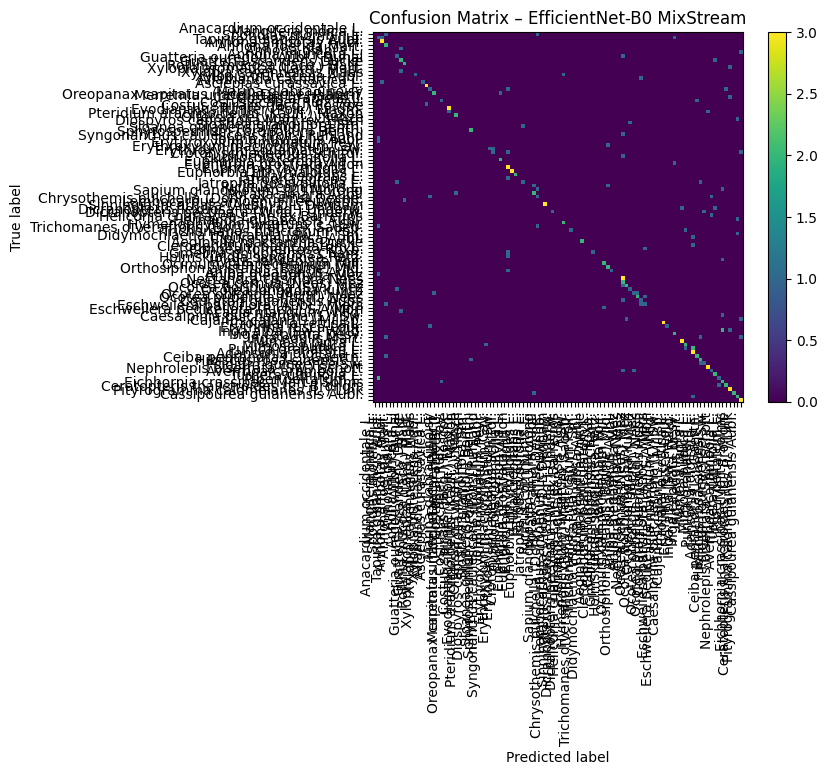

In [37]:
# ==========================================================
# 11) CONFUSION MATRIX
# ==========================================================

cm = confusion_matrix(test_labels, pred_top1)
plt.figure(figsize=(14,12))
disp = ConfusionMatrixDisplay(cm, display_labels=[idx_to_name[i] for i in range(NUM_CLASSES)])
disp.plot(include_values=False, cmap="viridis", xticks_rotation=90)
plt.title("Confusion Matrix – EfficientNet-B0 MixStream")
plt.show()



Displaying sample test predictions...


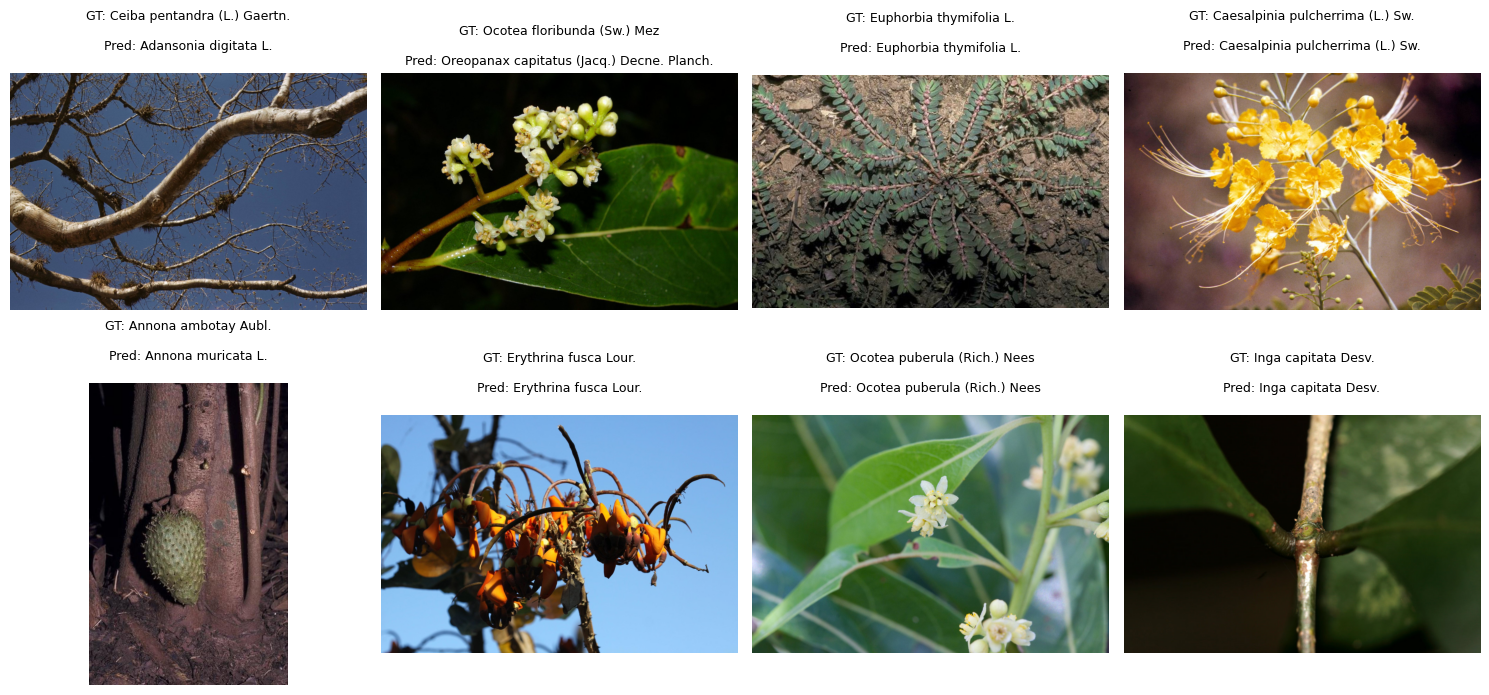

In [38]:
# ==========================================================
# 12) SHOW TEST EXAMPLES
# ==========================================================

def show_examples(k=8):
    sel = np.random.choice(len(test_paths), k, replace=False)
    plt.figure(figsize=(15,7))
    for n, i in enumerate(sel, 1):
        img = plt.imread(test_paths[i])
        plt.subplot(2, math.ceil(k/2), n)
        plt.imshow(img); plt.axis("off")
        gt = idx_to_name[test_labels[i]]
        pr = idx_to_name[pred_top1[i]]
        plt.title(f"GT: {gt}\nPred: {pr}", fontsize=9)
    plt.tight_layout()
    plt.show()

print("\nDisplaying sample test predictions...")
show_examples(8)